## Introduction

- We have taken `FashionMNIST` dataset and prepared a simple 2-layer NN model to uncover the fundamental concepts of PyTorch
- Before going into the DL portions, let us look at Tensors first

<hr>

## 0. What are Tensors

- Tensors are **like** numerical arrays that encode the input, output and weights/parameters of a model in the form of arrays and matrices.
- Typical 1D and 2D arrays:

![image](https://user-images.githubusercontent.com/24909551/157380975-0402a8ec-7f49-49a3-aef8-5fadc19d4c9c.png)
Source:  docs.microsoft.com/en-US/learn    

- How to imagine a 3D array:

![image](https://user-images.githubusercontent.com/24909551/157381034-056897c1-acea-459b-b43a-1b56d55b2434.png)
Source:  docs.microsoft.com/en-US/learn    

- Tensors work better on GPUs. They are optimized for **automatic differentiation**
- Tensors and numpy often have the same memory address. For example, review the code below <br>

```python
import numpy as np
import torch

data = [[1,2],[3,4]]
np_array = np.array(data)
tensor_array = torch.from_numpy(np_array)

# doing multiplication opearation on `np_array`
np.multiply(np_array,2,out=np_array)

print(f"Numpy array:{np_array}")
print(f"Tensor array:{tensor_array}")
```

```python
Numpy array:[[2 4]
 [6 8]]
Tensor array:tensor([[2, 4],
        [6, 8]])
```

**How to initialize a tensor?**: <br>

```python    
# directly from a python datastructure element
data = [[1,2],[3,4]]
x_tensor_from_data = torch.tensor(data)

# from numpy_array
np_array = np.array(data)
x_tensor_from_numpy = torch.from_numpy(np_array)

# from other tensors
x_new_tensor = torch.rand_like(x_tensor_from_data, dtype=torch.float) # dtype overrides the dtype of z_tensor_from_data
    
# random or new tensor of given shape
shape = (2,3,) # or just (2,3)
x_new_tensor_2 = torch.ones(shape)
```
    
**What are the `attributes` of a tensor?**:<br>

```python
print(f"{x_new_tensor_2.shape}")
print(f"{x_new_tensor_2.dtype}")
print(f"{x_new_tensor_2.device}") # whether stored in CPU or GPU
```

**When to use CPU and and when to use GPU while `operating` tensors?**: <br>

- Some common tensor operations include: Any arithmetic operation, linear algebra, matrix manipulation (transposing, indexing, slicing)
- Typical GPUs have 1000s of cores. GPUs can handle parallel processing.

![image](https://user-images.githubusercontent.com/24909551/159158293-6faec4f4-e959-4fa6-a5cf-114ddb83810b.png)
Source:  docs.microsoft.com/en-US/learn    

- Typical CPUs have 4 cores. Modern CPUs can have upto 16 cores. Cores are units that do the actual computation. Each core processes tasks in **sequential** order

![image](https://user-images.githubusercontent.com/24909551/159158302-d75e6fea-eaaa-4c01-a930-0b41a5cfde7c.png)
Source:  docs.microsoft.com/en-US/learn    

- Caveat: Copying large tensors across devices can be expensive w.r.t `time` and `memory`

- `PyTorch` uses Nvidia `CUDA` library in the backend to operate on GPU cards

```python
if torch.cuda._is_available():
    gpu_tensor = original_tensor.to('cuda') 
```

**What are the common tensor operations?**: <br>
- `Joining` or `ConCATenate`
```python
new_tensor = torch.cat([tensor, tensor],dim=1) # join along column if dim=1
```    
- `Matrix Multiplication`   
```python
# you would have to do the transpose
y1 = tensor @ tensor.T
y2 = tensor.matmul(tensor.T)
y3 = torch.rand_like(tensor)
torch.matmul(tensor, tensor.T, out=y3)
assert y1 = y2 = y3
```

- `Element-wise Multiplication`    
```python
z1 = tensor * tensor
z2 = tensor.mul(tensor)
z3 = torch.rand_like(tensor)
torch.mul(tensor, tensor, out=z3)
```  

- `Single element tensor` into python numerical value    
```python
sum_of_values = tensor.sum()
sum_of_values_python_variable = sum_of_values.item()
print(sum_of_values.dtype, type(sum_of_values_python_variable))
# >> torch.int64, <class 'int'>
```

- `In-place Operations`    

```python
# add in_place
tensor.add_(5)
```

```
# transpose  in place
tensor.t_()

```   

Summary of the key operations

 - `torch.cuda.is_available()` gives a boolean output
 - `torch.tensor(x)` <br>
  - x could be a 1D or 2D iterable (list or tuple) <br>
 - `torch.ones_like(tensor_variable)`, `torch.rand_like(tensor_variable)` <br>
 - `torch.ones(shape_in_a_tuple_or_list)` , `torch.zeros(shape_in_a_tuple_or_list)` and  `torch.rand(shape_in_a_tuple_or_list)` <br>
 - `torch_tensor_variable[start_index:end_index:step_value]` (similar to a numpy indexing)
 - numpy to torch tensor: `torch.from_numpy(np_array)`
 - torch_tensor to numpy: `torch_tensor_variable.numpy()`
 - Concatenate across rows `torch.cat((an_iterable_of_tensors),dim=0)`<br>
 - Concatenate across columns `torch.cat((an_iterable_of_tensors),dim=1)` <br>
 - tensor multiplication `tensor1 * tensor2 == torch.mul(tensor1,tensor2,out=tensor3) == tensor1.mul(tensor2)` <br>
 - convert single_element_tensor into a python datatype using `.item()` --> `single_element_tensor = tensor1.sum(); python_variable = single_element_tensor.item()` <br>
 - In-place Operations in torch using `_`: `x.add_(5)` will add 5 to each element of x <br>
 - tensor `n = t.numpy()` & np.add(n,2,out=n) --> A change in `n` will automatically change `t` (vice versa is true too)

<hr>

Importing relevant modules

In [15]:
#| code-fold: true
%matplotlib inline
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
# torchvision.datasets module contains `Dataset` objects for many real-world vision data
from torchvision import datasets # other domain-specific libraries TorchAudio, TorchText
from torchvision.transforms import (
    ToTensor, # for normalizing the pixel values to the range [0,1]
    Lambda, # to make user-defined functions as one of the transformations 
    )
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
import numpy as np

<hr>

## 1. Dataset and DataLoaders

Two data `primitives` to handle data efficiently: <br>
- `torch.utils.data.Dataset`
- `torch.utils.data.DataLoader` 

**How should the data be preprocessed before training in DL?**: <br>
- Pass samples of data in `minibatches`
- reshuffle the data at every epoch to overfitting
- leverage Python's `multiprocessing` to speed up data retrieval

**`torch.utils.data.DataLoader` abstracts all the above steps**


What does `Dataset` do?
- `Dataset`: Stores data samples and their corresponding labels
- `DataLoader`: Wraps an iterable around Dataset to enable easy access to the samples. `DataLoader` can also be used along with `torch.multiprocessing`
- `torchvision.datasets` and `torchtext.datasets` are both subclasses of `torch.utils.data.Dataset` (they have __getitem__ and __len__ methods implemented) and also they can be passed to a `torch.utils.data.DataLoader`


**What does normalization do?**: <br>
- Changes the range of the data
- When one pixel value is 15 and another pixel is 190, the higher pixel value will deviate the learning 

**Why do we do normalization of data before training a DL**:
- Prediction accuracy is better for normalized data
- Model can learn faster if data is normalized


**More details on PyTorch Primitives**

- `torchvision.datasets` --> to use pre-existing datasets like FashionMNIST, coco, cifar, etc.,
- torchvision.datasets have arguments/parameters to `transform` featuers (aka inputs) and `target_transform` to transform labels (like one hot encoding of labels
- CustomDatasetClass must overwrite the `magic methods` of python such as 
        - `__init__`, `__getitem__` and `__len__` methods inherited from `Dataset`
- `torchvision.transforms.ToTensor` (to transform/modify the features) and `torchvision.transforms.Lambda` (to transform the target/labels)
        - `torchvision.transforms.ToTensor()` converts features to normalized tensors
        - `torchvision.transforms.Lambda` could be used to transform labels
        - `Lambda(lambda y: torch.zeros(number_of_classes,dtype=torch.float).scatter_(dim=0, index=torch.tensor(y), value=1)
                  )`
        - `Tensor.scatter_` is used to change values of a tensor variable at specified indices

### 1A. Converting Data into Model Suitable Iterables 

- Downloading and transforming the datasets
- Preparing train, validation and test datasets

In [ ]:
# help(datasets.FashionMNIST)
help(datasets.MNIST)

In [3]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

/opt/conda/lib/python3.7/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448265233/work/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [5]:
print(test_data.test_labels[0:5])

tensor([9, 2, 1, 1, 6])


In [6]:
training_data.class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

```python
# If you have a custom dataset in your location

class CustomImageDataset(Dataset):
    """FashionMNIST like Image Dataset Class"""
    def __init__(self, 
                 annotations_file,
                 img_dir,
                 transform=None,
                 target_transform=None):
        """
        Args:
            transform (Optional): dataset will take an optional argument transform 
                so that any required processing can be applied on the sample
        """
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
    
    def __len__(self):
        return len(self.img)
    
    def __getitem__(self, idx):
        # format of data 
        # image_location, label_type
        # tshirt1.jpg, T-shirt/top # class needs to be convered into numerical format
        # pant4.jpg, Trouser # class needs to be convered into numerical format
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx,0])
        image = tvio.read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        sample = {"image": image, "label": label}
        return sample


# target_transform
# turn the integer y values into a `one_hot_encoded` vector 
# 1. create a zero tensor of size 10 torch.zeros(10, dtype=torch.float)
# 2. `scatter_` assigns a value =1
the_target_lambda_function = Lambda(lambda y: torch.zeros(10,
                                    dtype=troch.float).scatter_(dim=0,
                                                    index=torch.tensor(y), value=1))


training_data = CustomImageDataset(
    root="data", # the path where the train/test data is stored
    train=True, # False if it is a test dataset 
    download=False, # downloads the data from Web if not available at root
    transform=ToTensor(), # transform the features; converts PIL image or numpy array into a FloatTensor and scaled the image's pixel intensity to the range [0,1]
    target_transform=the_target_lambda_function
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=False,
    transform=ToTensor(),
    target_transform=the_target_lambda_function
    # target_transform=torch.nn.functional.one_hot(y, num_classes=10) # alternate way
)
```

Preparing Validation Data from Test Data

In [7]:
indices = list(range(len(training_data)))
np.random.shuffle(indices)

print(indices[0:5])

[7400, 11594, 9947, 24051, 56426]


In [8]:
split = int(np.floor(0.2 * len(training_data)))
training_data_sample = SubsetRandomSampler(indices[split:])
validation_data_sample = SubsetRandomSampler(indices[:split])

Convert into iterables

In [17]:
batchsize = 4

# create iterables 
train_dataloader = DataLoader(training_data, sampler=training_data_sample, batch_size=batchsize)
validation_dataloader = DataLoader(training_data, sampler=validation_data_sample, batch_size=batchsize)
test_dataloader = DataLoader(test_data, batch_size=batchsize)

print(len(train_dataloader))
print(len(validation_dataloader))
print(len(test_dataloader))

# to understand the shape of input features and output
for X,y in test_dataloader:
    print("Shape of Features:",X.shape)
    print("Shape of Labels:",y.shape)
    break

12000
3000
2500
Shape of Features: torch.Size([4, 1, 28, 28])
Shape of Labels: torch.Size([4])


In [18]:
len(train_dataloader)

12000

- The above shape of training image is in the format NCHW
- batchsize N, no. of channels C, height H, width W

### 1B. Visualize sample data

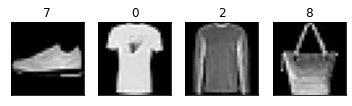

In [23]:
dataiter = iter(train_dataloader)
images, labels = dataiter.next()

fig = plt.figure(figsize=(5,5))

for idx in np.arange(4):
    ax = fig.add_subplot(1, 4, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title(labels[idx].item())
    fig.tight_layout()

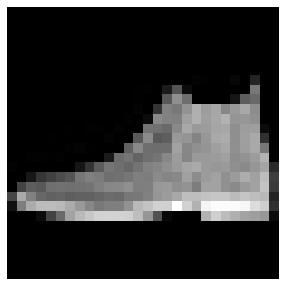

In [24]:
# looking into just one image, label

figure = plt.figure(figsize=(5,5))
img, label = test_data[0]

plt.axis("off")
plt.imshow(img.squeeze(),cmap="gray")

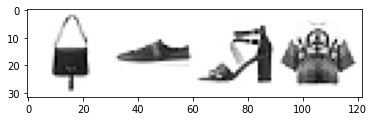

In [25]:
# Helper function for inline image display
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
        
dataiter = iter(train_dataloader)
images, labels = dataiter.next()

# Create a grid from the images and show them
img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid, one_channel=True)

### 1C. Initiating the Tensorboard Logs and Visualizing Sample Images

In [27]:
# specifying the log directory
writer = SummaryWriter('runs/fashion_mnist_2_layer_NN_experiment_1')

# writing the grid of 4 images to Tensorboard log dir
writer.add_image('Four Sample Fashion-MNIST Images', img_grid)
writer.flush()

**How to load the tensorboard**

To view, start TensorBoard on the command line with:
- `tensorboard --logdir=runs`
- and open a browser tab to http://localhost:6006/
- Can view the sample images in `images` tab 

- Load the TensorBoard notebook extension for jupyter notebook
```
%load_ext tensorboard
```

- Run the tensorboard from jupyter notebook

```
%tensorboard --logdir runs/fashion_mnist_2_layer_NN_experiment_1
```

<hr>

## 2. Build the Model Layers

Build a NN with **2 hidden layers** and 1 output layer

**Components of a Neural Network**:

- Typical Neural Network: <br>

![image](https://user-images.githubusercontent.com/24909551/160055546-f6150c41-acb0-44a4-942e-0d20c86e8972.png)

- Activation Function, Weight and Bias

![image](https://user-images.githubusercontent.com/24909551/160055714-0bfb081d-6c1b-4733-a226-d7db71e74fec.png)

- Linear weighted sum of inputs: x = &sum;(`weights` * `inputs`) + `bias`    
- f(x) = activation_func(x)

- Activation Functions add non-linearity to the model    
- Different Activation Functions: <br>
    - **Sigmoid**: <sup>1</sup>/<sub>(1 + exp(-x))</sub>
    - **Softmax**: <sup>exp(x)</sup> / <sub>(sum(exp(x)))</sub>
    - **ReLU**: max(0,x)
    - **Tanh**: <sup>(exp(x) - exp(-x))</sup>/<sub>(exp(x) + exp(-x))</sub>

**Building a neural network in PyTorch** 
- `torch.nn` class provides all the building block needed to build a NN
- Every module/layer in PyTorch subclases the `torch.nn.Module`
- A NN is a composite module consisting of other modules (layers)
    
    
- Initialize all layers in `__init__` module
- Build a 3-layer NN with 
    - flattened `28*28` image as input,
    - 2 hidden layers will have 512 neurons each and
    - the third layer (which also has relu activation function) will have 10 neurons each corresponding to the number of classes
  

In [28]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device}")

Using cuda


In [29]:
# defining the model architecture

class NeuralNetwork(nn.Module):
    def __init__(self):
        # initialize the layers in __init__ constructor
        super(NeuralNetwork,self).__init__()
        # supercharge your sub-class by inheriting the defaults from Parent class
        self.flatten = nn.Flatten()
        # one can also use Functional API in PyTorch 
        # but below codes use Sequential API
        # the below stack of layers generates scores or logits
        self.linear_relu_stack = nn.Sequential(
            # hidden layer 1 consisting of 512 neurons
            nn.Linear(28*28, 512),
            nn.ReLU(),
            # hidden layer 2 consisting of 512 neurons too
            nn.Linear(512,512),
            nn.ReLU(),
            # output layer consisting of 10 neurons 
            nn.Linear(512,10),
            # we can also build a NN without this final layer ReLU
            # instead can also run the log_softmax directly
            nn.ReLU(), 
        )
        
    def forward(self,x): # need to pass the input argument x
        # function where the input is run through 
        # the initialized layers
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits
    
# create a instance of the class NeuralNetwork 
# move it to the device (CPU or GPU)
model = NeuralNetwork().to(device)

# print model structure
print(model)

# is nn.ReLU in the final layer?
# https://ai.stackexchange.com/questions/8491/does-it-make-sense-to-apply-softmax-on-top-of-relu

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
    (5): ReLU()
  )
)


- Why `model(X)` instead of `model.forward(X)`? <br>
[Source](https://stackoverflow.com/questions/55338756/why-there-are-different-output-between-model-forwardinput-and-modelinput) 

Dissecting the steps using Functional API

- **Step 1**:Convert `28*28` into a contiguous array of 784 pixel values
    
```python
input_image = torch.rand(3, 28, 28)
print(input_image.size())
# step 1: Flatten the input image
flatten = nn.Flatten() # instantitate
flat_image = flatten(input_image)  # pass the prev layer (input) into the instance
print(flat_image.size())
```
- **Step 2**: Dense or linear layer in PyTorch `weight * input + bias`
    
```python    
# step 2: apply linear transformation `weight * input + bias`
layer1 = nn.Linear(in_features=28*28, out_features=512) # instantiate
hidden1 = layer1(flat_image) # pass the prev layer (flattened image) into the instance
print(hidden1.size())
```

- **Step 3**: Apply Relu activation on the linear transformation
    
```python
relu_activation = nn.ReLU() #instantiate
hidden1 = relu_activation(hidden1)
```    
Repeat Step 2 and 3 for `hidden2`: <br>

```python
layer2 = nn.Linear(in_features=512, out_features=512)
hidden2 = layer2(hidden1)
hidden2 = relu_activation(hidden2)
```    
    
- **Step 4**: Compute the logits
    
```python
# a simple 1 hidden layer NN with 20 neurons in the hidden layer
nn_seq_modules = nn.Sequential(
                    flatten,
                    layer1,
                    relu_activation,
                    layer2,
                    relu_activation,
                    nn.Linear(512, 10), # the output                )
input_image = torch.rand(3, 28, 28)
logits =  nn_seq_modules(input_image)   
```
    
- **Step 5**: Apply `Softmax` function
    
```python

softmax = nn.Softmax(dim=1)
predict_probab = softmax(logits)

```

- Full NN workflow: 
 
![image](https://user-images.githubusercontent.com/24909551/161696907-8672f820-3293-4390-b153-bf702731352d.png)
Source: docs.microsoft.com/en-US/learn    


**How to see internal layers of a NN in PyTorch**:

```python
print("Weights stored in first layer: {model.linear_relu_stack[0].weight} \n")
print("Bias stored in first layer: {model.linear_relu_stack[0].bias} \n") 
    
from name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()}"
```
    
```bash
Layer: linear_relu_stack.0.weight | Size: torch.Size([512, 784])
Layer: linear_relu_stack.0.bias | Size: torch.Size([512])
Layer: linear_relu_stack.2.weight | Size: torch.Size([512, 512])
Layer: linear_relu_stack.2.bias | Size: torch.Size([512])
Layer: linear_relu_stack.4.weight | Size: torch.Size([10, 512])
Layer: linear_relu_stack.4.bias | Size: torch.Size([10])
```  

<hr>

## 3. Training the Model 
Training with training data and evaluating loss on Validation Data

### 3A.Setting Hyperparameters

- `num_of_epochs`: The number of times the entire training dataset is pass through the network
- `batch_size`: The number of data samples seen by the model before updating its weights. (derived parameter `steps = total_training_data/batch_size` - the number of batches needed to complete an epoch)
- `learning_rate`: How much to change the weights in the `w = w - learning_rate * gradient`. Smaller value means the model will take a longer time to find best weights. Larger value of learning_rate might make the NN miss the optimal weights because we might step over the best values
- Choice of `loss_fn` <br>
Common Loss Functions for classification problems :    
    - `nn.NLLLoss` #Negative Log Likelihood    
    - `nn.CrossEntropyLoss` # combination of `nn.LogSoftmax` and `nn.NLLLoss`   
- Choice of `optimizers` <br>
    - `torch.optim.SGD`
    - `torch.optim.Adam`
    - `torch.optim.RMSProp` and many more ...

In [30]:
num_of_epochs = 40
batchsize = 4 # already mentioned in the DataLoader arguments
learning_rate = 1e-3

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),
                            lr=learning_rate
                           )
# SGD optimizer in PyTorch actually is Mini-batch Gradient Descent with momentum
# it updates one mini-batch at a time (batchsize)
# Source: https://discuss.pytorch.org/t/how-sgd-works-in-pytorch/8060

### 3B. Writing Core Training and Evaluation Loop Functions

- `loss_fn` and `optimizer` are passed to `train_loop` and just `loss_fn` to `test_loop`
```python
for i in range(epochs):
    print(f"Epoch {i+1}\n ----------------------------")
    train_loop(train_dataloader, validation_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader,model, loss_fn)
print("Over!")    
```

In [33]:
def train_loop(train_dataloader, validation_dataloader, model, loss_fn, optimizer, epoch):
    train_size = len(train_dataloader.dataset)
    validation_size = len(validation_dataloader.dataset)
    training_loss_per_epoch = 0
    validation_loss_per_epoch = 0
    for batch_number, (X,y) in enumerate(train_dataloader):
        X,y = X.to(device), y.to(device)
        
        # compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)
        
        # Backpropagation steps
        # key optimizer steps
        # by default, gradients add up in PyTorch
        # we zero out in every iteration
        optimizer.zero_grad() 
        # performs the gradient computation steps (across the DAG)
        loss.backward()
        # adjust the weights
        optimizer.step()
        training_loss_per_epoch += loss.item()
        
#         if batch_number % 100 == 0:
#             print(f"After completing {batch_number * len(X)} samples, the loss is:")
#             print(loss.item()) 
            
    for batch_number, (X,y) in enumerate(validation_dataloader):
        X,y = X.to(device), y.to(device)
        
        # compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)
        
        validation_loss_per_epoch += loss.item()
    avg_training_loss = training_loss_per_epoch/train_size
    avg_validation_loss = validation_loss_per_epoch/validation_size
    print(f"Average Training Loss of {epoch}: {avg_training_loss}")
    print(f"Average Validation Loss of {epoch}: {avg_validation_loss}")
    writer.add_scalars('Training vs. Validation Loss',
                       {'Training': avg_training_loss, 
                        'Validation': avg_validation_loss
                       },
                       epoch
                      )

In [34]:
def test_loop(test_dataloader,model, loss_fn, epoch):
    test_size = len(test_dataloader.dataset)
    # Failing to do eval can yield inconsistent inference results
    model.eval()
    test_loss_per_epoch, accuracy_per_epoch = 0, 0
    # disabling gradient tracking while inference
    with torch.no_grad():
        for X,y in test_dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            loss = loss_fn(pred, y)
            test_loss_per_epoch += loss.item()
            accuracy_per_epoch += (pred.argmax(1)==y).type(torch.float).sum().item()
    print(f"Average Test Loss of {epoch}: {test_loss_per_epoch/test_size}")
    print(f"Average Accuracy of {epoch}: {accuracy_per_epoch/test_size}")

### 3C. Training the model for many epochs

In [35]:
%%time
for epoch in range(num_of_epochs):
    print(f"Epoch Number: {epoch} \n---------------------")
    train_loop(train_dataloader, validation_dataloader, model, loss_fn, optimizer, epoch)
    test_loop(test_dataloader,model, loss_fn, epoch)

Epoch Number: 0 
---------------------
Average Training Loss of 0: 0.37492141907910503
Average Validation Loss of 0: 0.07822599628902972
Average Test Loss of 0: 0.3941003955438733
Average Accuracy of 0: 0.4513
Epoch Number: 1 
---------------------
Average Training Loss of 1: 0.29412952572156986
Average Validation Loss of 1: 0.06984573040464893
Average Test Loss of 1: 0.3524202892445028
Average Accuracy of 1: 0.5089
Epoch Number: 37 
---------------------
Average Training Loss of 37: 0.13975639427933614
Average Validation Loss of 37: 0.037423237568447926
Average Test Loss of 37: 0.19380079013922005
Average Accuracy of 37: 0.7052
Epoch Number: 38 
---------------------
Average Training Loss of 38: 0.13921849230745761
Average Validation Loss of 38: 0.038412615390023046
Average Test Loss of 38: 0.19745682889677718
Average Accuracy of 38: 0.7015
Epoch Number: 39 
---------------------
Average Training Loss of 39: 0.13862396091737622
Average Validation Loss of 39: 0.03721317019570803
Averag

*truncated the results for easy viewing* 

Points to ponder: 
- The accuracy for this 2-layer NN stands at 71%. 
- The Hyperparameters - batch_size, learning_rate, choice of optimizer - can be varied to see how results change.
- **Changing Architecture**: Deepening the number of hidden layers can help in improving the accuracy or changing the architecture to use CNN or any pre-trained NN like *LeNet-5* or others will improve further

### 3D. Saving, Loading and Exporting the model

In [36]:
!mkdir -p model_weights/

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.utf-8)


In [37]:
torch.save(model.state_dict(),"model_weights/fmnist_2_layer_nn_model_batch_size_4.pth")

**How to save and load the model for inference?**    
```python    
# pytorch models save the parameters in a internal state dictionary called `state_dict`
torch.save(model.state_dict(),"data/modelname.pth")
    
# infer from a saved model
# instantiate the model architecture class
model = NeuralNetwork()
model.load_state_dict(torch.load("data/modelname.pth"))
# the eval method is called before inferencing so that the batch normalization dropout layers are set to `evaluation` mod
# Failing to do this can yield inconsistent inference results
model.eval()
```    

**How to export a pytorch model to run in any Programming Language/Platform**: <br>
    
- **ONNX**: Open Neural Network Exchange 
- Converting `PyTorch` model to `onnx` format aids in running the model in Java, Javascript, C# and ML.NET
    
```python
# while explorting pytorch model to onnx, 
# we'd have to pass a sample input of the right shape
# this will help produce a `persisted` ONNX model    
import torch.onnx as onnx
input_image = torch.zeros((1,28,28))
onnx_model_location = 'data/model.onnx'
onnx.export(model, input_image, onnx_model)
```    

<hr>

## 4. Predict using the Trained Model
Loading the trained model and predicting for unseen data

In [38]:
# construct the model structure
model = NeuralNetwork()
# load the state_dict
model.load_state_dict(torch.load("model_weights/fmnist_2_layer_nn_model_batch_size_4.pth"))

classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Ankle boot", Actual: "Ankle boot"


In [39]:
# these are logit scores and not softmax outputs 
# yet they are enough for predicting the class 
# since the logits are finally coming out of a ReLU() unit
# A ReLU outputs from (0,max)
pred[0]

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.4451, 0.0000, 0.0000, 0.0000,
        5.6093])

<hr>

## 5. Leveraging Tensorboard

Reiterating the steps we have already done using Tensorboard

- 1.Specifying the Log directory and using `add_images` method

```python
# `torch.utils.data.tensorboard.SummaryWriter` class
# specifying the log directory
writer = SummaryWriter('runs/fashion_mnist_2_layer_NN_experiment_1')

# writing the grid of 4 images to Tensorboard log dir
# we can look at `IMAGES` tab of Tensorboard for this
writer.add_image('Four Sample Fashion-MNIST Images', img_grid)
writer.flush()
```

- 2.Tracking Epoch level Average Training and Validation Losses. 

```python 
# We can track in the `SCALARS` tab of the Tensorboard
writer.add_scalars('Training vs. Validation Loss',
                   {'Training': avg_training_loss, 
                    'Validation': avg_validation_loss
                   },
                   epoch
                  )
```

**The Graph of Training Loss (blue line) and Validation Loss (green line) in Tensorboard**

![](./pytorch_nn/training_and_validation_loss_over_epochs.png)

- 3.After trained model is obtained, we can look at the graph to trace the sample input through your model

```python
# We can track in the `GRAPH` tab of the Tensorboard
dataiter = iter(train_dataloader)
images, labels = dataiter.next()

# add_graph() will trace the sample input through your model
writer.add_graph(model, images)
writer.flush()
```

**NN_graph in Tensorboard**
![](./pytorch_nn/NN_Tensorboard_graph.png)


<hr>

## 6. Sources and GitHub Links <br>
**Sources**:
- MSFT PyTorch Course | [link](https://docs.microsoft.com/en-us/learn/modules/intro-machine-learning-pytorch/8-quickstart)
- PyTorch Official Tutorial Explaining with FashionMNIST data | [link](https://pytorch.org/tutorials/beginner/introyt/tensorboardyt_tutorial.html)
- A useful Medium article on FashionMNIST dataset | [link](https://medium.com/@aaysbt/fashion-mnist-data-training-using-pytorch-7f6ad71e96f4)

**Github Links**:
- Dockerfile to replicate the environment | [link](https://github.com/senthilkumarm1901/myCodingProjects/blob/main/SpacyNER/docker/Dockerfile.txt)
- To replicate the DL workflow described here | [Notebook link](https://github.com/senthilkumarm1901/PythonTutorials/blob/master/PyTorch_Tutorials/Microsoft_PyTorch_Course/PyTorch_NN_model_on_FashionMNIST_Tensorboard.ipynb)

<hr>